In [116]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


## Imports

In [117]:
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

np.random.seed(23)

In [170]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MultiLabelBinarizer, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

## Getting the Data

In [119]:
train = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv")
test = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv")
movies = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv")

In [120]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB
None


In [121]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55315 entries, 0 to 55314
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movieid       55315 non-null  object
 1   reviewerName  55315 non-null  object
 2   isTopCritic   55315 non-null  bool  
 3   reviewText    52805 non-null  object
dtypes: bool(1), object(3)
memory usage: 1.3+ MB
None


In [122]:
print(movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               143258 non-null  object 
 1   title                 143258 non-null  object 
 2   audienceScore         73248 non-null   float64
 3   rating                13991 non-null   object 
 4   ratingContents        13991 non-null   object 
 5   releaseDateTheaters   30773 non-null   object 
 6   releaseDateStreaming  79420 non-null   object 
 7   runtimeMinutes        129431 non-null  float64
 8   genre                 132175 non-null  object 
 9   originalLanguage      129400 non-null  object 
 10  director              143258 non-null  object 
 11  boxOffice             14743 non-null   object 
 12  distributor           23005 non-null   object 
 13  soundType             15917 non-null   object 
dtypes: float64(2), object(12)
memory usage: 15.3+ MB
Non

## Initial Preprocessing

Most preprocessing should be handled after the EDA stage. That being said, some glaring issues stand out from just the initial look with the info() method, and thus those issues will be handled immediately. 

We can immediately see the column 'isFrequentReviewer' is labelled differently in the train and test data. It is good to fix that so that any transformations made on the train data can properly be replicated on the test data. 

In [123]:
train.rename(columns={'isFrequentReviewer': 'isTopCritic'}, inplace=True)
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   movieid       162758 non-null  object
 1   reviewerName  162758 non-null  object
 2   isTopCritic   162758 non-null  bool  
 3   reviewText    156311 non-null  object
 4   sentiment     162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB
None


The info method highlights one more key issue, missing values in the reviewText column in both the train and test datasets. As this column is absolutely key to our analysis, imputation is not the correct course of action. Instead, it is better to drop the rows that do not contain a review. 

In [124]:
train = train.dropna()
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156311 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   movieid       156311 non-null  object
 1   reviewerName  156311 non-null  object
 2   isTopCritic   156311 non-null  bool  
 3   reviewText    156311 non-null  object
 4   sentiment     156311 non-null  object
dtypes: bool(1), object(4)
memory usage: 6.1+ MB
None


In [125]:
test = test.dropna()
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52805 entries, 0 to 55314
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movieid       52805 non-null  object
 1   reviewerName  52805 non-null  object
 2   isTopCritic   52805 non-null  bool  
 3   reviewText    52805 non-null  object
dtypes: bool(1), object(3)
memory usage: 1.7+ MB
None


## EDA and Preprocessing of movies.csv

Let us take a deep dive into each individual feature in the movies dataset. This will help us with feature engineering and feature selection. 

In [126]:
print(movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               143258 non-null  object 
 1   title                 143258 non-null  object 
 2   audienceScore         73248 non-null   float64
 3   rating                13991 non-null   object 
 4   ratingContents        13991 non-null   object 
 5   releaseDateTheaters   30773 non-null   object 
 6   releaseDateStreaming  79420 non-null   object 
 7   runtimeMinutes        129431 non-null  float64
 8   genre                 132175 non-null  object 
 9   originalLanguage      129400 non-null  object 
 10  director              143258 non-null  object 
 11  boxOffice             14743 non-null   object 
 12  distributor           23005 non-null   object 
 13  soundType             15917 non-null   object 
dtypes: float64(2), object(12)
memory usage: 15.3+ MB
Non

#### Title

Domain knowledge tells us the title of a movie has very little correlation with its quality and the sentiment of its reviews. As we already have the movieid column to identify the movie, the title column is unnecessary, and can be dropped from the get-go. 

In [127]:
movies = movies.drop('title', axis=1)

#### Audience Score

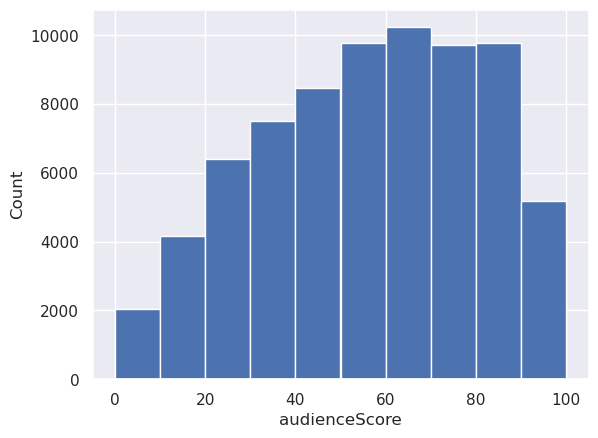

In [128]:
sns.set()
movies.audienceScore.hist()
plt.xlabel('audienceScore')
plt.ylabel('Count')
plt.show()

Domain knowledge tells us that audience score is probably a very important variable in predicting whether a review for a given movie is positive or negative. If the audience score is very high, most reviews about it should be positive, and vice versa. 

Audience score has missing values and they can be imputed with the median.

In [129]:
si_audscore = SimpleImputer(strategy='median')
movies[['audienceScore']] = si_audscore.fit_transform(movies[['audienceScore']])

#### Rating

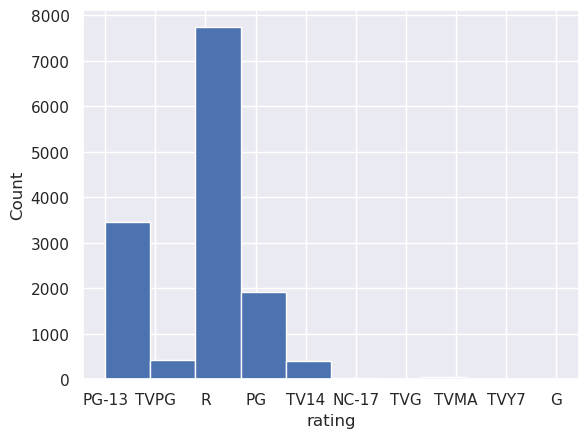

In [130]:
sns.set()
movies.rating.hist()
plt.xlabel('rating')
plt.ylabel('Count')
plt.show()

In [131]:
movies['rating'].isnull().value_counts()

True     129267
False     13991
Name: rating, dtype: int64

The vast majority of the ratings column, 89%, is null values. Further, domain knowledge tells us that a movie's rating should have little connection as to whether its reviews are positive or negative. Therefore, this column will be dropped in the subsequent analysis. 

In [132]:
movies = movies.drop('rating', axis=1)

#### Rating Contents

In [133]:
print(movies.ratingContents.value_counts())
print(movies['ratingContents'].isnull().value_counts())

['Language']                                                                                   365
['V']                                                                                          155
['Some Language']                                                                              143
['Some Violence']                                                                              126
['L']                                                                                          105
                                                                                              ... 
['Incidental Smoking', 'Some Language', 'Mild Thematic Elements']                                1
['Language', 'Drug Material', 'Nudity', 'Sexual Content', 'Strong Violence']                     1
['A Disturbing Image', 'Some Thematic Material']                                                 1
['Pervasive Sexual Content', 'Aberrant Sexuality', 'Some Drug Material', 'Strong Language']      1
['Language

Similar to Rating, the ratingContents column mostly has missing values. Imputation is dangerous when 89% of the values of a column are null. Further, domain knowledge tells us there should be no direct connection between a movie's rating contents and the general sentiment of its reviews. This column will also be dropped in the subsequent analysis. 

In [134]:
movies = movies.drop('ratingContents', axis=1)

#### Release Date (Theatres and Streaming)

In [135]:
movies.releaseDateTheaters.head(10)

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5    2018-06-01
6           NaN
7           NaN
8           NaN
9    1947-04-30
Name: releaseDateTheaters, dtype: object

In [136]:
movies.releaseDateTheaters.isnull().value_counts()

True     112485
False     30773
Name: releaseDateTheaters, dtype: int64

There are too many null values for imputation to be safe for the model's analysis. It is better to drop the release date column. 

In [137]:
movies = movies.drop('releaseDateTheaters', axis=1)
movies = movies.drop('releaseDateStreaming', axis=1)

#### Runtime

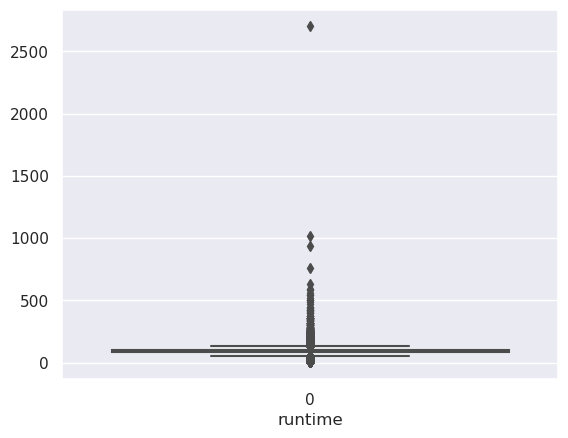

In [138]:
sns.boxplot(movies['runtimeMinutes'])
plt.xlabel('runtime')
plt.show()

As we can see from the boxplot, runtime has a lot of high-value outliers. This could make the column dangerous for analysis.

In [139]:
movies.runtimeMinutes.isnull().value_counts()

False    129431
True      13827
Name: runtimeMinutes, dtype: int64

Runtime has a reasonable number of missing values and therefore the column should not be dropped. Rather, the missing values should be imputed. Because there are many outliers with extremely large values, the only safe method of imputation is the median. 

In [140]:
si_runtime = SimpleImputer(strategy='median')
movies[['runtimeMinutes']] = si_runtime.fit_transform(movies[['runtimeMinutes']])

#### Original Language

In [141]:
movies.originalLanguage.isnull().value_counts()

False    129400
True      13858
Name: originalLanguage, dtype: int64

Most of the values in the Original Language column are not null. 

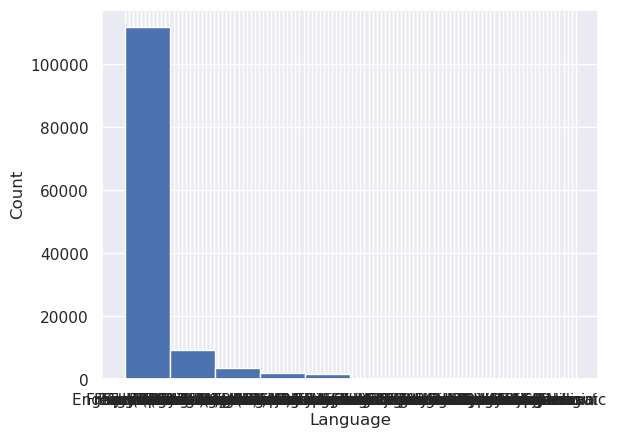

In [142]:
sns.set()
movies.originalLanguage.hist()
plt.xlabel('Language')
plt.ylabel('Count')
plt.show()

In [143]:
movies.originalLanguage.value_counts()

English            85034
Spanish             4786
Japanese            3482
Hindi               3309
French (Canada)     3282
                   ...  
Bhojpuri               1
Hawaiian               1
Yoruba                 1
smi                    1
Aramaic                1
Name: originalLanguage, Length: 112, dtype: int64

As we can see, the vast majority of movies are in English. However, a significant portion of them are in other languages too. 

#### Director

In [144]:
movies.director.isnull().value_counts()

False    143258
Name: director, dtype: int64

Director has no missing values.

In [145]:
movies.director.value_counts()

Joseph Brooks     4194
Augusta Daniel    3544
Cory Simmons       129
Mary Garrett       124
David Mceachin      93
                  ... 
Michael Garner       1
Luz Sanderson        1
Thomas Lamar         1
Carol Brune          1
Roy Lovelace         1
Name: director, Length: 62208, dtype: int64

There are over 62,000 different directors in the dataset. This will make it problematic to use onehot encoding on this column. Upon further inspection, it seems the model will perform better without this column. 

In [146]:
movies = movies.drop('director', axis = 1)

#### Box Office

In [147]:
movies.boxOffice.isnull().value_counts()

True     128515
False     14743
Name: boxOffice, dtype: int64

Box office earnings should be a very useful indicator of a movie's quality. Rememeber, the assumption is that the higher a movie's quality, the more likely it is to get positive reviews, and vice versa. Unfortunately, 90% of the values in this column are missing values, and that is just too high to make including this column a viable option. Therefore, it will be dropped from the subsequent analysis 

In [148]:
movies = movies.drop('boxOffice', axis=1)

#### Distributor

In [149]:
movies.distributor.isnull().value_counts()

True     120253
False     23005
Name: distributor, dtype: int64

A movie's distributor could in theory be correlated with its quality. Different distributors likely have different standards for the movies they are willing to publish, and other such connections between a movie's distributor and its quality are likely to exist. Unfortunately, similar to above, the column has too many missing values. Including it in the analysis would be problematic, and constant or mode imputation would both be potentially dangerous for our model's accuracy. 

In [150]:
movies = movies.drop('distributor', axis=1)

#### Sound Type

In [151]:
movies.soundType.isnull().value_counts()

True     127341
False     15917
Name: soundType, dtype: int64

Not only does soundType have too many missing values, domain knowledge tells us it should not be closely related to a movie's quality. This is a column we can easily drop without regret. 

In [152]:
movies = movies.drop('soundType', axis=1)

#### Genre

In [153]:
movies.genre.isnull().value_counts()

False    132175
True      11083
Name: genre, dtype: int64

Genre doesn't have too many missing values. Furthermore, it should be very useful to our analysis. Genre will be addressed and preprocessed in a later section.

### Cleaning movies.csv

Unfortunately, the movies dataset is unclean, with multiple rows for the same movie id. These rows need to be combined so that there is only one row for each movie id to aid our future analysis, especially the upcoming join that will be done between movies and train and test. 

In [154]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   movieid           143258 non-null  object 
 1   audienceScore     143258 non-null  float64
 2   runtimeMinutes    143258 non-null  float64
 3   genre             132175 non-null  object 
 4   originalLanguage  129400 non-null  object 
dtypes: float64(2), object(3)
memory usage: 5.5+ MB


In [155]:
movies = movies.groupby('movieid').agg({
    'audienceScore':np.mean,
    'runtimeMinutes':np.mean,
    'genre': lambda x: ', '.join(x.dropna().unique()),
    'originalLanguage': lambda x: x.mode()[0] if not x.mode().empty else None,
}).reset_index()

In [156]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126404 entries, 0 to 126403
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   movieid           126404 non-null  object 
 1   audienceScore     126404 non-null  float64
 2   runtimeMinutes    126404 non-null  float64
 3   genre             126404 non-null  object 
 4   originalLanguage  114589 non-null  object 
dtypes: float64(2), object(3)
memory usage: 4.8+ MB


The original language column still has missing values. As 80% of the column is 'English', it is a very strong mode, and a good strategy to impute the data. 

In [157]:
movies['originalLanguage'].fillna('English', inplace=True)

#### Preprocessing of genre

Currently, genre is a string. It should be converted to a list so that multilabel encoding will work on it. 

In [158]:
movies['genre'] = movies['genre'].str.split(", | & ").tolist()

#### Merging movies and train

In [159]:
merge_df = pd.merge(train, movies, on='movieid', how='left')

### Encoding

We can drop reviewerName and movieid as they are not important for the analysis. 

In [160]:
merge_df = merge_df.drop('reviewerName', axis = 1)
merge_df = merge_df.drop('movieid', axis = 1)

Let us keep sentiment aside as it is the label column. We will also apply label encoding on sentiment so that it becomes numerical.

In [161]:
y = merge_df['sentiment']
merge_df = merge_df.drop('sentiment', axis = 1)

In [162]:
le = LabelEncoder()
y = le.fit_transform(y)
y.shape

(156311,)

In [163]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156311 entries, 0 to 156310
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   isTopCritic       156311 non-null  bool   
 1   reviewText        156311 non-null  object 
 2   audienceScore     156311 non-null  float64
 3   runtimeMinutes    156311 non-null  float64
 4   genre             156311 non-null  object 
 5   originalLanguage  156311 non-null  object 
dtypes: bool(1), float64(2), object(3)
memory usage: 7.3+ MB


#### One-Hot and Ordinal Encoding

In [174]:
ct = ColumnTransformer(transformers=[
    ('istopcritic_encoder', OrdinalEncoder(), ['isTopCritic']),
    ('language_encoder', OneHotEncoder(), ['originalLanguage']),
], remainder = 'drop')

encoded_data = ct.fit_transform(merge_df)
encoded_data.shape

(156311, 89)

#### Encoding the genre column

In [165]:
mlb = MultiLabelBinarizer()
genre_array = mlb.fit_transform(merge_df['genre'])
genre_array.shape

(156311, 40)

#### Encoding the reviewText column

In [166]:
tfidf_vect = TfidfVectorizer(stop_words='english', max_features = 1000)
tfidf_matrix = tfidf_vect.fit_transform(merge_df['reviewText'])
tfidf_matrix.shape

(156311, 1000)

#### Feature Scaling audienceScore and runtimeMinutes

In [168]:
encoded1 = merge_df.drop(['reviewText', 'isTopCritic', 'genre', 'originalLanguage'], axis = 1)

In [172]:
mms = MinMaxScaler()
encoded1 = mms.fit_transform(encoded1)

array([[0.65      , 0.18132855],
       [0.52      , 0.18132855],
       [0.8       , 0.22621185],
       ...,
       [0.78      , 0.15439856],
       [0.39      , 0.1508079 ],
       [0.57      , 0.14721724]])

Combining encoded matrices

In [179]:
final_df = np.concatenate((encoded1, genre_array, tfidf_matrix), axis = 1)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 2 has 0 dimension(s)